In [297]:
import numpy as np
import pandas as pd
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
from torchviz import make_dot
import hiddenlayer as hl
from torch.utils.tensorboard import SummaryWriter
from torchviz import make_dot
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [298]:
df = pd.read_csv('EEG_data.csv')
dfdem = pd.read_csv('demographic_info.csv')

In [299]:
dfdem.rename(columns={'subject ID': 'SubjectID'}, inplace=True)
data = dfdem.merge(df, on='SubjectID')
data.head()

,SubjectID,age,ethnicity,gender,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0,25,Han Chinese,M,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0,25,Han Chinese,M,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0,25,Han Chinese,M,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0,25,Han Chinese,M,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0,25,Han Chinese,M,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [300]:
data = data.drop(['SubjectID', 'VideoID', 'predefinedlabel'], axis=1)
data.rename(columns={'user-definedlabeln':'label'}, inplace=True)
data['label'] = data['label'].astype(int)

In [301]:
data

,age,ethnicity,gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,label
0,25,Han Chinese,M,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0
1,25,Han Chinese,M,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0
2,25,Han Chinese,M,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0
3,25,Han Chinese,M,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0
4,25,Han Chinese,M,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,24,Han Chinese,F,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,0
12807,24,Han Chinese,F,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,0
12808,24,Han Chinese,F,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,0
12809,24,Han Chinese,F,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,0


In [250]:
print(f'number of missing values:{data.isna().sum().sum()}')

number of missing values:0


In [302]:
data = data.rename(columns = {' age': 'age', ' ethnicity': 'ethnicity'
, ' gender': 'gender'})

In [303]:
data.columns

Index(['age', 'ethnicity', 'gender', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'label'],
      dtype='object')

In [304]:
data['ethnicity'].unique()

array(['Han Chinese', 'English', 'Bengali'], dtype=object)

In [305]:
ethnicity_dummies = pd.get_dummies(data['ethnicity'])
data = pd.concat([data, ethnicity_dummies], axis=1)
data = data.drop('ethnicity', axis=1)

<Axes: >

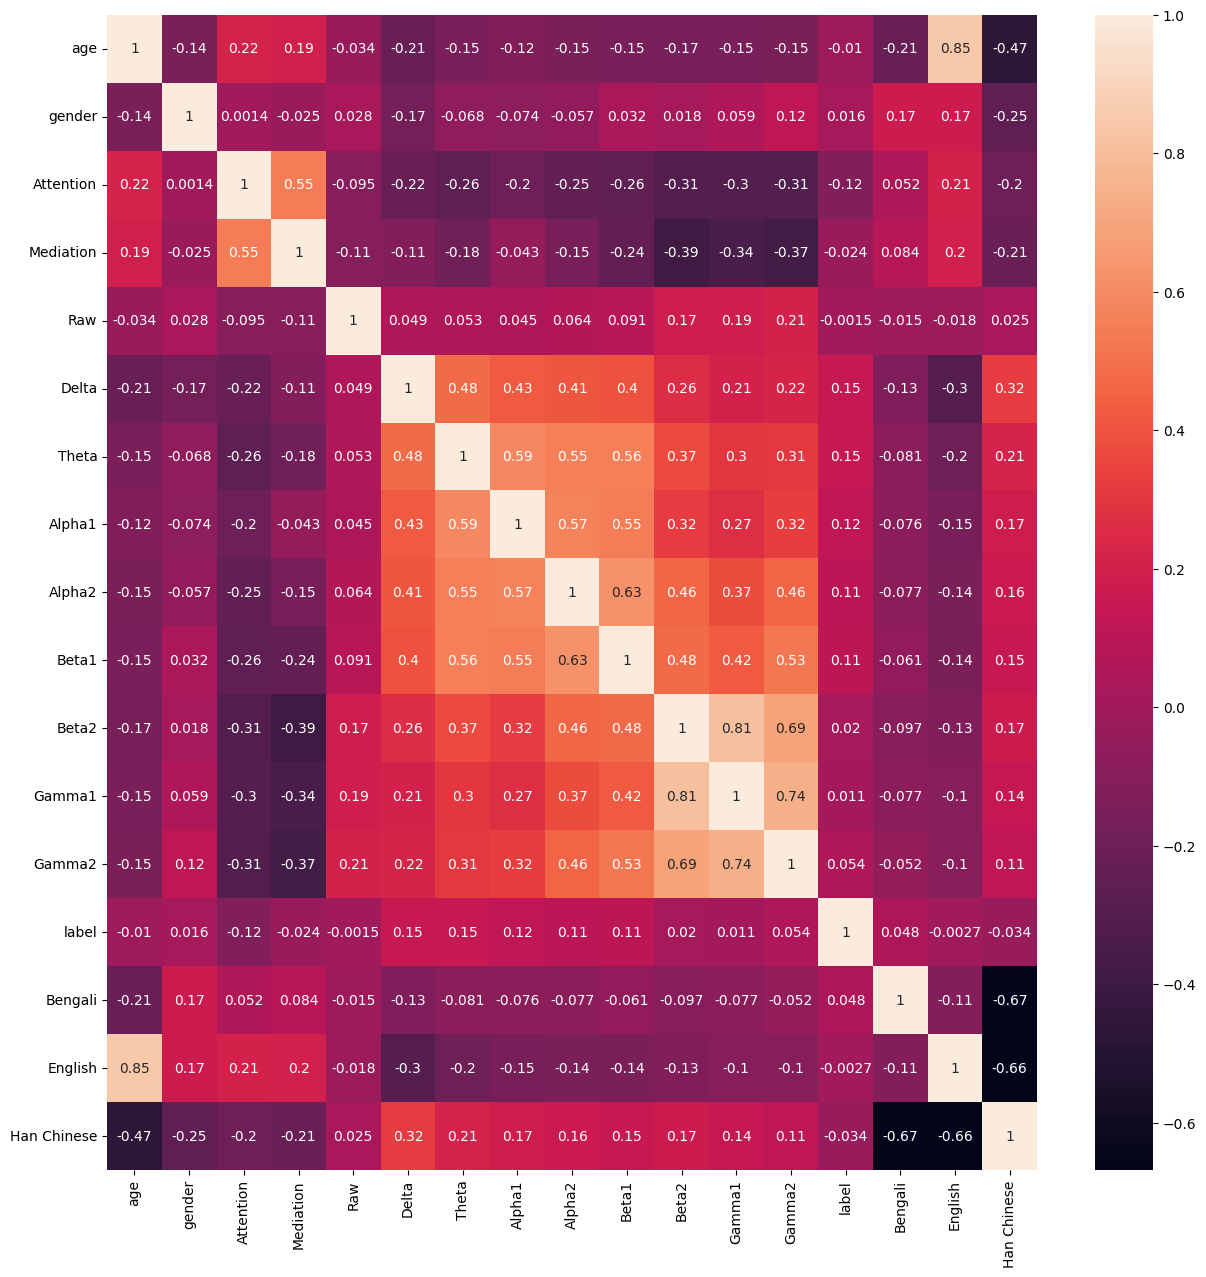

In [306]:
#Encode categorical variables
data['gender'] = data['gender'].apply(lambda g: 1 if g == 'M' else 0)
data['Bengali'] = data['Bengali'].apply(lambda x: 1 if x == True else 0)
data['English'] = data['English'].apply(lambda x: 1 if x == True else 0)
data['Han Chinese'] = data['Han Chinese'].apply(lambda x: 1 if x == True else 0)
#data['ethnicity'] = data['ethnicity'].apply(lambda ethnicity: encoding[ethnicity])

plt.figure(figsize = (15,15))
cor_matrix = data.corr()
sns.heatmap(cor_matrix,annot=True)

In [307]:
eda_copy = data.drop('label', axis=1).copy()

In [308]:
data.columns

Index(['age', 'gender', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta',
       'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'label',
       'Bengali', 'English', 'Han Chinese'],
      dtype='object')

In [309]:
categorical_features = ['age', 'gender', 'Bengali', 'English', 'Han Chinese']
continuous_features = ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']


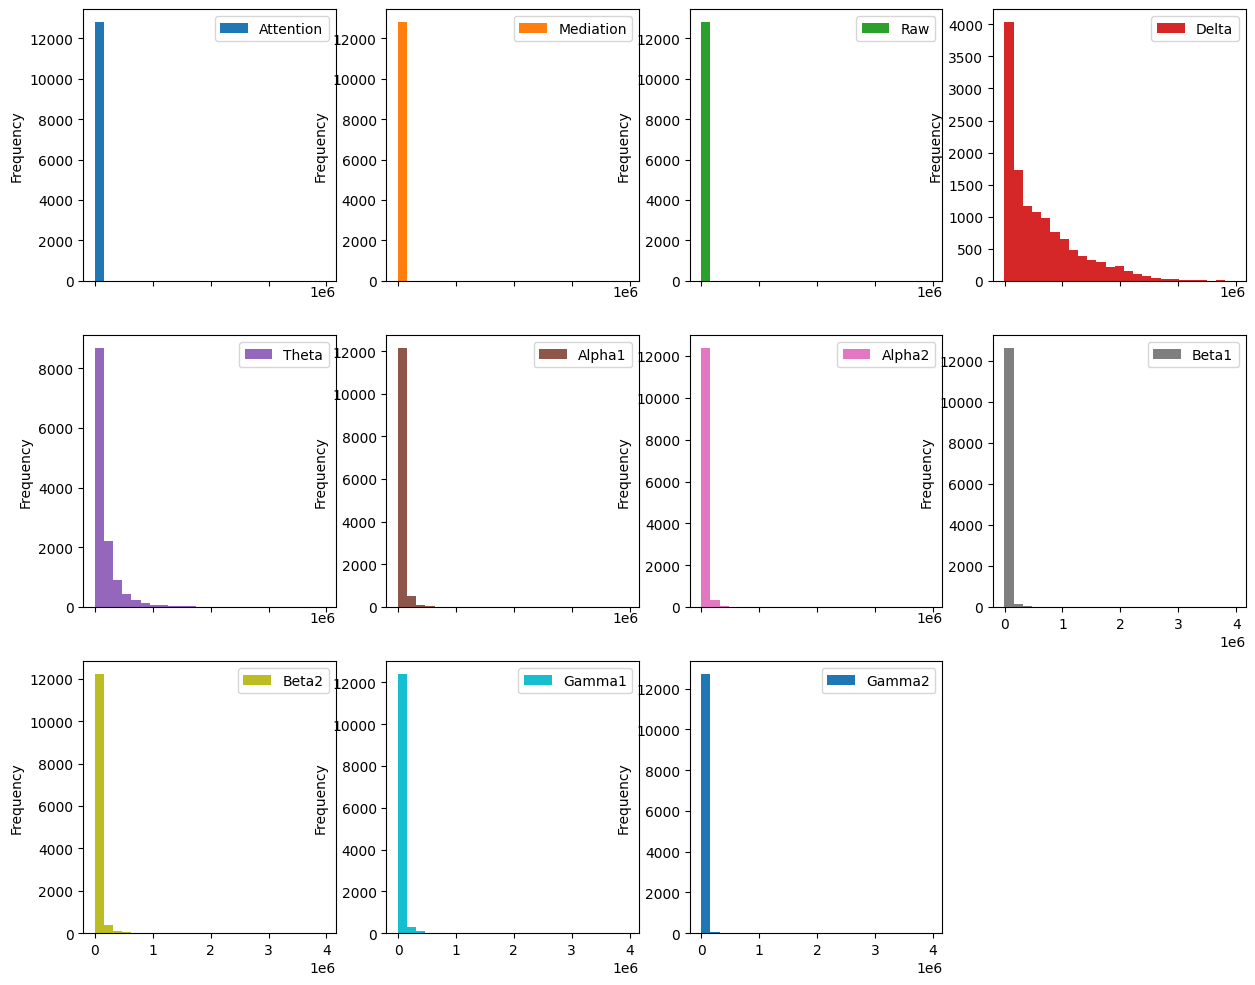

In [310]:
eda_copy[continuous_features].plot(kind='hist', bins=25, figsize=(15, 12), subplots=True, layout=(3, 4))
plt.show()

In [311]:
# Lets treat this as a binary classification task where we want to predict the
# output label
y = data['label'].copy()
X = data.drop('label', axis=1).copy()

In [312]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [314]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(list(y_train))
y_test = torch.Tensor(list(y_test))
y_val = torch.Tensor(list(y_val))


In [319]:
X_train.shape

torch.Size([7173, 16])

In [320]:
num_training_data = X_train.shape[0]
input_size = X_train.shape[1]

In [265]:
writer = SummaryWriter("torchlogs/")
writer.add_graph(model, X_train)
writer.close()

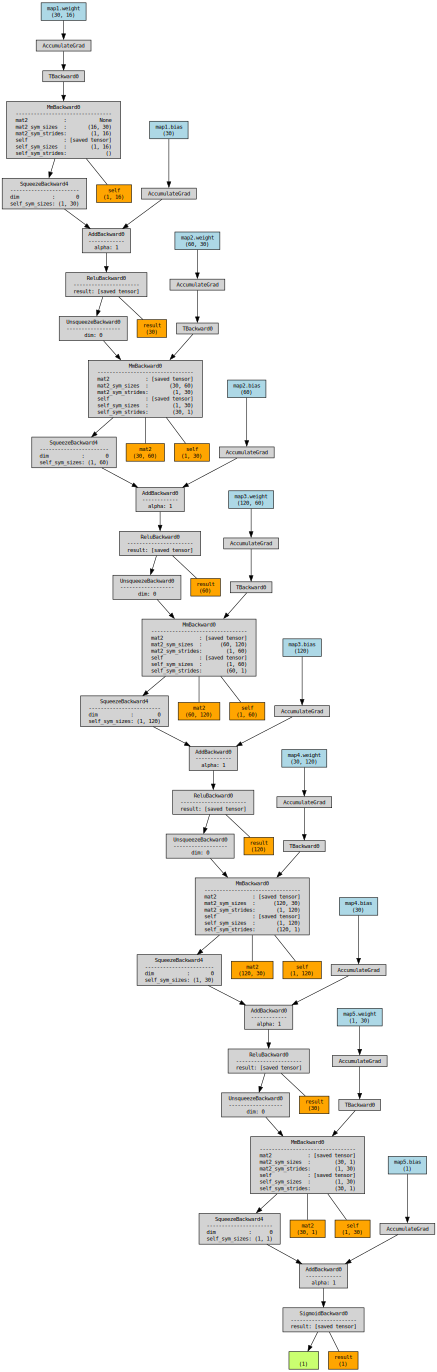

In [266]:
make_dot(model(X_train[0]), params=dict(model.named_parameters()),
         show_attrs=True, show_saved=True, 
          )

In [321]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [322]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        #self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], 
               #self.y_data[index]
    
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
#Val data
class ValData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

val_data = ValData(torch.FloatTensor(X_val),torch.FloatTensor(y_val))

In [323]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# batch size is 1 for test loader
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader= DataLoader(dataset = val_data, batch_size = BATCH_SIZE)

In [365]:
class Classifier(nn.Module):
    def __init__(self, input_size, h1, output_size):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.map1 = nn.Linear(input_size, h1)
        self.map2 = nn.Linear(h1, output_size)
              

        self.xfer = nn.ReLU()
        self.xfer2 = nn.Sigmoid()

    def forward(self, x):
        x = self.xfer( self.dropout(self.map1(x)) )
        return self.xfer2( self.map2( x ) )

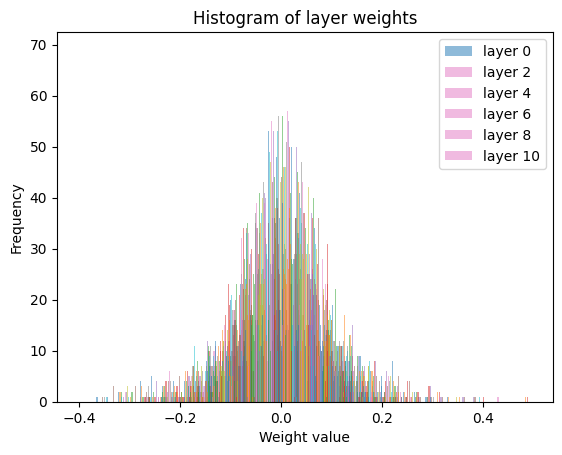

In [271]:
    # histogram of the weights checking if normally distributed (Xavier initialisation)
fig, ax = plt.subplots()

for i, data in enumerate([weights for weights in ClassificationNN.parameters()]):
        if i % 2 == 0:
            ax.hist(data.detach().numpy(), bins=20, alpha=0.5, label=f'layer {i}')

ax.set_xlabel('Weight value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of layer weights')
ax.legend()
plt.show()

In [366]:
ClassificationNN = Classifier(
    input_size=input_size,
    h1=30,
    output_size=1)

In [367]:
num_epochs, lr = 500, 0.1
optimizer = optim.SGD(ClassificationNN.parameters(), lr = lr)
BATCH_SIZE = 64
criterion = nn.BCEWithLogitsLoss()

In [368]:
loss = []
loss_values = []
training_acc = []
valid_loss_classifier = []
validation_acc = []

In [375]:
ClassificationNN.train()
for e in range(1, num_epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
 
        
        optimizer.zero_grad()
        y_pred =ClassificationNN(X_batch)    
        loss = criterion(y_pred, y_batch.reshape(-1,1))
        acc = binary_acc(y_pred, y_batch.reshape(-1,1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    
    loss_values.append((epoch_loss/len(train_loader)))
    training_acc.append(epoch_acc/len(train_loader))
    
    
    
    #print(torch.cat((y_pred,y_batch),1))
    valid_loss = 0
    val_acc = 0 
    model.eval()
    for X_batch,y_batch in val_loader:
        val_pred = ClassificationNN(X_batch)
        
        val_loss = criterion(val_pred,y_batch.reshape(-1,1))
        val_accuracy = binary_acc(val_pred,y_batch.reshape(-1,1))
        
        val_acc += val_accuracy.item()
        valid_loss += val_loss.item()
    valid_loss_classifier.append(valid_loss/len(val_loader))
    validation_acc.append(val_acc/len(val_loader))
    
    

    
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.65985 | Acc: 54.947
Epoch 002: | Loss: 0.65838 | Acc: 55.575
Epoch 003: | Loss: 0.65586 | Acc: 55.142
Epoch 004: | Loss: 0.65971 | Acc: 55.168
Epoch 005: | Loss: 0.65704 | Acc: 55.336
Epoch 006: | Loss: 0.65883 | Acc: 55.204
Epoch 007: | Loss: 0.66041 | Acc: 55.354
Epoch 008: | Loss: 0.65724 | Acc: 55.504
Epoch 009: | Loss: 0.65832 | Acc: 55.708
Epoch 010: | Loss: 0.65759 | Acc: 55.257
Epoch 011: | Loss: 0.65773 | Acc: 55.531
Epoch 012: | Loss: 0.65793 | Acc: 55.372
Epoch 013: | Loss: 0.65921 | Acc: 55.681
Epoch 014: | Loss: 0.65772 | Acc: 55.442
Epoch 015: | Loss: 0.65790 | Acc: 55.265
Epoch 016: | Loss: 0.65762 | Acc: 55.602
Epoch 017: | Loss: 0.65770 | Acc: 55.699
Epoch 018: | Loss: 0.65852 | Acc: 55.982
Epoch 019: | Loss: 0.66018 | Acc: 54.991
Epoch 020: | Loss: 0.66104 | Acc: 55.416
Epoch 021: | Loss: 0.65673 | Acc: 55.230
Epoch 022: | Loss: 0.65715 | Acc: 55.460
Epoch 023: | Loss: 0.65929 | Acc: 55.513
Epoch 024: | Loss: 0.65886 | Acc: 55.425
Epoch 025: | Los

In [382]:
x = nn.Sequential()

In [380]:
loss_values = loss_values[:1000]
valid_loss_classifier = valid_loss_classifier[:1000]

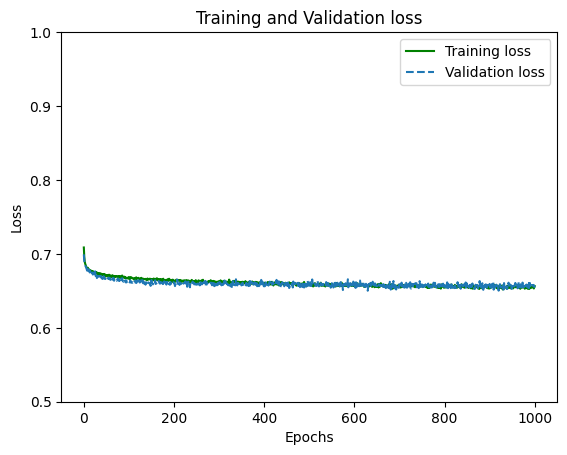

In [381]:
runs = 2
plt.plot(np.linspace(0,num_epochs*runs,num_epochs*runs), loss_values, 'g', label='Training loss')
plt.plot(np.linspace(0,num_epochs*runs,num_epochs*runs), valid_loss_classifier, '--', label='Validation loss')
plt.ylim(0.5,1)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.linspace(0,num_epochs,num_epochs), training_acc, 'g', label='Training accuracy')
plt.plot(np.linspace(0,num_epochs,num_epochs), validation_acc, '--', label='Validation accuracy')
plt.ylim(75,101)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        yreg_test_pred = net_reg(X_batch)